# **Final Project Unit 3: Modeling**

## *DATA 3300*
## Name(s): Cabot Steward



# **Final Project Task**

**Our task is to analyze a provided dataset containing information on current Airbnb listings in the Nashville area. The objective is to explore the data comprehensively and provide informed recommendations to Aggie Investments regarding the potential of entering this market, the types of listings they should acquire, and how they should manage those listings.**
_____

**In Unit 3, you learned how to perform various forms of unsupervised data mining. You will now apply each of these forms to the dataset in order to draw insights from the airbnb property data and make actionable recommendations to Aggie Investments in terms of the key factors they should look for when searching for properties to invest in!**

**Let's begin as always by loading in the dependencies and the `data3300_airbnb_data_clean_final.csv` file!**

In [1]:
# pip install the kneed library (for cluster analysis portion)
!pip install kneed

In [2]:
# load in required libraries for correlation, association rules, and cluster analyses
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import requests

from sklearn.experimental import enable_iterative_imputer
from sklearn.impute import IterativeImputer

from mlxtend.frequent_patterns import apriori, association_rules

from scipy.stats import ttest_ind, pearsonr, spearmanr, ttest_1samp, ttest_rel

from kneed import KneeLocator
import sklearn.cluster
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score
from sklearn.preprocessing import StandardScaler
from sklearn.manifold import TSNE

import warnings
warnings.filterwarnings('ignore')

## **Correlation Analysis and T-Tests**

### **Data Transformations**

**1) We know from unit 2 that there are some remaining variables with outliers that have not been addressed. Let's start by checking the distributions of our *quantitative* variables to see if there are remaining transformations to conduct.**

In [4]:
# read in the dataset data3300_airbnb_data_clean_final.csv
df = pd.read_csv('data3300_airbnb_data_clean_final.csv')

In [5]:
# check data types using df.info for each variable to determine what is qualitative and what is quantitative
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 8808 entries, 0 to 8807
Data columns (total 29 columns):
 #   Column                          Non-Null Count  Dtype  
---  ------                          --------------  -----  
 0   Unnamed: 0                      8808 non-null   int64  
 1   id                              8808 non-null   float64
 2   host_id                         8808 non-null   int64  
 3   host_is_superhost               8808 non-null   int64  
 4   calculated_host_listings_count  8808 non-null   int64  
 5   host_has_profile_pic            8808 non-null   int64  
 6   host_identity_verified          8808 non-null   int64  
 7   host_listings_count             8808 non-null   int64  
 8   neighbourhood_cleansed          8808 non-null   object 
 9   availability_365                8808 non-null   int64  
 10  minimum_nights                  8808 non-null   int64  
 11  room_type                       8808 non-null   object 
 12  accommodates                    88

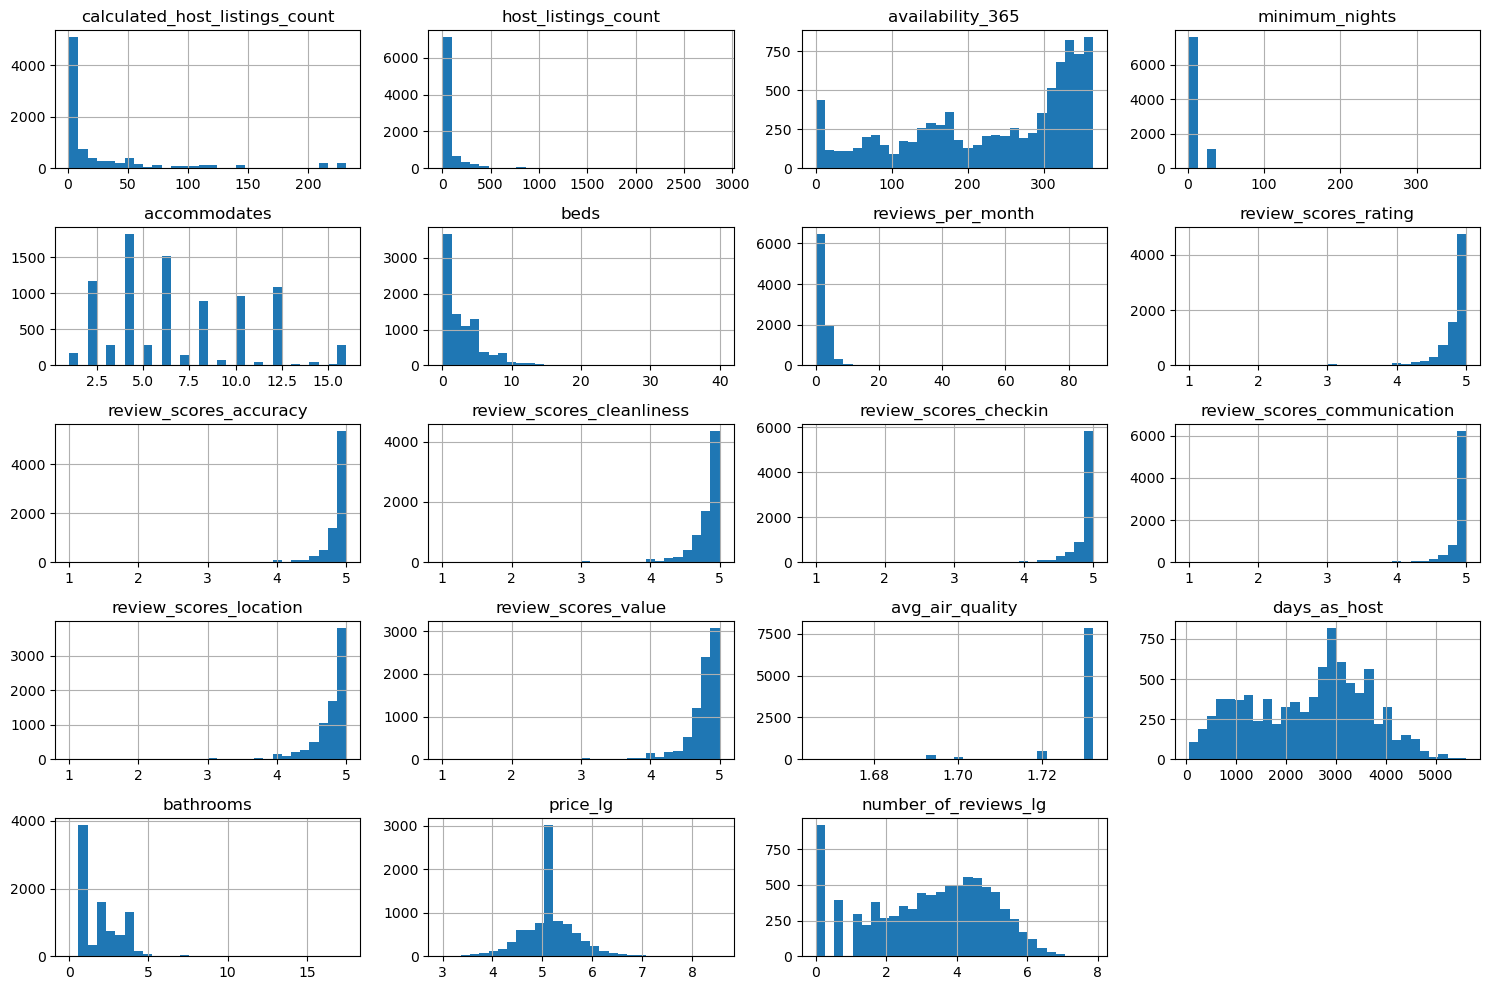

In [9]:
# create a subset of your full dataframe called df_corr where you drop the primary key variables and other qualitative variables
cols_to_drop = ['Unnamed: 0', 'id', 'host_id', 
                'host_is_superhost', 'host_has_profile_pic', 
                'host_identity_verified', 'short_term']

df_corr = df.drop(columns=cols_to_drop).select_dtypes(include=[np.number])

df_corr.hist(bins=30, figsize=(15, 10))
plt.tight_layout()
plt.show()

**2) Are there any variables that follow a roughly normal distribution, that do NOT require transformation?**

Normal Ish - days_as_host, price_lg, number_of_reviews_lg

**3) Transform the remaining non-normal variables using a square root transformation:**

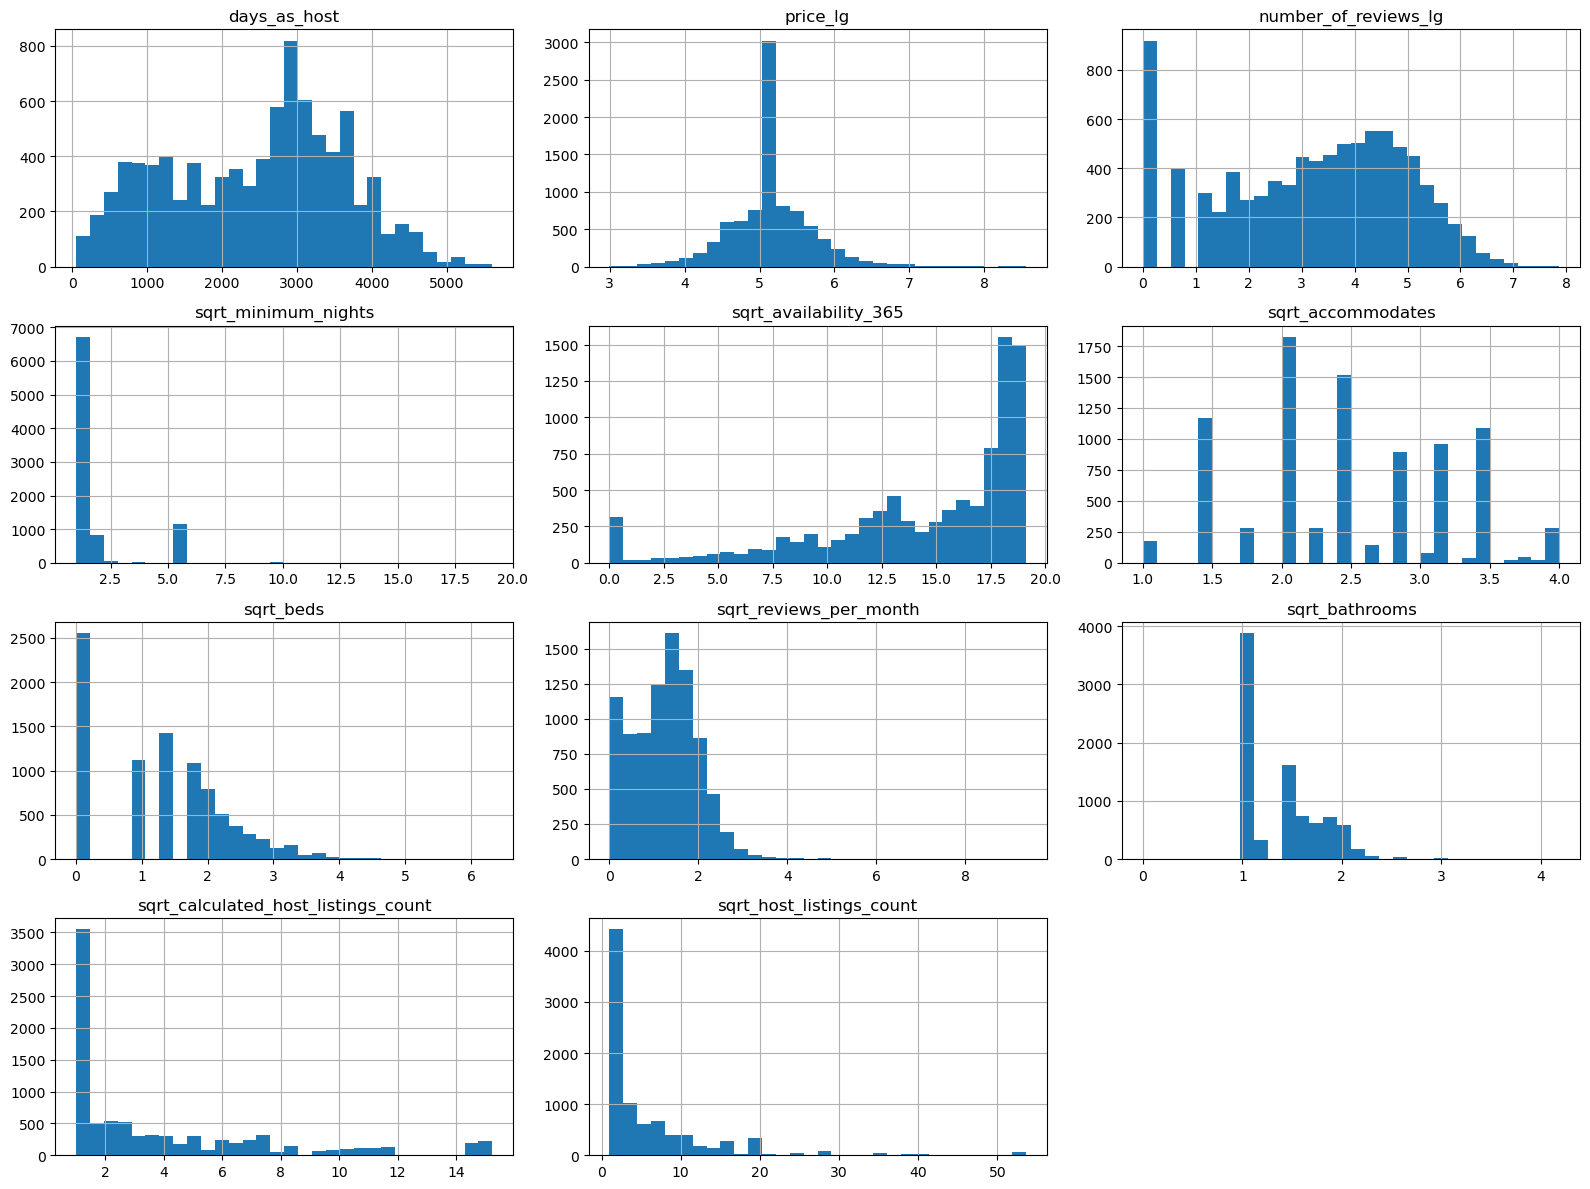

In [10]:
# create a new dataframe called df_corrT to store your transformed variables
df_corrT = pd.DataFrame()

df_corrT['days_as_host'] = df_corr['days_as_host']
df_corrT['price_lg'] = df_corr['price_lg']
df_corrT['number_of_reviews_lg'] = df_corr['number_of_reviews_lg']

square_root_vars = ['minimum_nights', 'availability_365', 'accommodates', 'beds',
                    'reviews_per_month', 'bathrooms', 'calculated_host_listings_count',
                    'host_listings_count']

for col in square_root_vars:
    df_corrT[f'sqrt_{col}'] = np.sqrt(df_corr[col])


# generate histograms to check transformed variable distributions
df_corrT.hist(bins=30, figsize=(16, 12))
plt.tight_layout()
plt.show()

**4) Why would we do a square root transformation on these variables over a log transformation?**

We do square root over log because many of these values contain 0 which with log will leave it as undefined. 

**5) Are there remaining transformed variables that are still not normal AND if so, what is the implication of running parametric analyses (e.g., t-test, pearson correlation)?**

Yes — even after square root transformations, some variables still show skew (e.g., sqrt_host_listings_count, sqrt_bathrooms, sqrt_minimum_nights).  Running these analyses on this could cause us to see misleading correlations

### **Correlation Analysis**
**6) Let's implement a non-parametric correlation analysis (spearman) on our dataset, then answer why we are doing spearman correlation in place of pearson correlation:**

In [ ]:
# run a spearman correlation analysis on your dataframe, then store values in cor_matrix
cor_matrix = df_corrT.corr(method='spearman')

styled_matrix = cor_matrix.round(2).style.background_gradient(cmap='coolwarm', axis=None)

styled_matrix

,days_as_host,price_lg,number_of_reviews_lg,sqrt_minimum_nights,sqrt_availability_365,sqrt_accommodates,sqrt_beds,sqrt_reviews_per_month,sqrt_bathrooms,sqrt_calculated_host_listings_count,sqrt_host_listings_count
days_as_host,1.000000,-0.050000,0.220000,0.130000,-0.070000,-0.030000,0.040000,0.020000,0.010000,-0.020000,-0.050000
price_lg,-0.050000,1.000000,0.040000,-0.040000,0.100000,0.550000,0.380000,0.040000,0.500000,0.060000,0.070000
number_of_reviews_lg,0.220000,0.040000,1.000000,-0.180000,-0.060000,0.040000,0.190000,0.770000,-0.050000,-0.150000,-0.250000
sqrt_minimum_nights,0.130000,-0.040000,-0.180000,1.000000,-0.090000,-0.030000,0.010000,-0.350000,0.080000,-0.240000,-0.220000
sqrt_availability_365,-0.070000,0.100000,-0.060000,-0.090000,1.000000,0.220000,0.120000,-0.070000,0.180000,0.340000,0.300000
sqrt_accommodates,-0.030000,0.550000,0.040000,-0.030000,0.220000,1.000000,0.410000,0.050000,0.830000,0.210000,0.180000
sqrt_beds,0.040000,0.380000,0.190000,0.010000,0.120000,0.410000,1.000000,0.230000,0.320000,0.080000,0.020000
sqrt_reviews_per_month,0.020000,0.040000,0.770000,-0.350000,-0.070000,0.050000,0.230000,1.000000,-0.070000,-0.120000,-0.220000
sqrt_bathrooms,0.010000,0.500000,-0.050000,0.080000,0.180000,0.830000,0.320000,-0.070000,1.000000,0.210000,0.160000
sqrt_calculated_host_listings_count,-0.020000,0.060000,-0.150000,-0.240000,0.340000,0.210000,0.080000,-0.120000,0.210000,1.000000,0.920000


**Answer**:

**7) Next, lets consider the price variable, which will likely be quite important to Aggie Investments since it's a metric related to revenue. a) Select a variable you think should be related to price (either positively or negatively), b) produce a set of hypotheses, c) then test them!**

* Var 1: Price
* Var 2: sqrt_accommodates

---
* $H_o:$ There is no monotonic relationship between price and accommodate
* $H_A:$ There is a monotonic relationship between price and accommodate

In [13]:
# Calculate the Spearman correlation coefficient and p-value for your two variables
corr, p_value = spearmanr(df_corrT['price_lg'], df_corrT['sqrt_accommodates'])

print('Spearman correlation coefficient:', round(corr, 3))
print('P-value:', round(p_value, 5))

Spearman correlation coefficient: 0.549
P-value: 0.0


 **8) How would you describe the strength and direction of the relationship between price and your chosen variable? Is their relationship statistically significant, how do you know?**

The relationship between price and accommodates is moderately strong and positive, with a Spearman correlation coefficient of approximately 0.55.
The relationship is statistically significant because the p-value is less than 0.05, which indicates we can reject the null hypothesis of no monotonic relationship.

(I dont feel like a rebel...)

**9) If you wanted to train a model to predict price, which 5 other variables would you choose as predictor variables (i.e., which 5 are most strongly correlated with price)?**



1.  sqrt_accommodates 
2.  sqrt_bathrooms 
3.  sqrt_beds 
4.  sqrt_calculated_host_listings_count 
5.  sqrt_host_listings_count 



### **T Tests**

**Next, let's implement some t-tests to examine potential meaningful group differences in price.**

**10) What variables could we use to group price (hint: remember t-tests can only compare TWO groups)?**

host_is_superhost, host_has_profile_pic, host_identity_verified, short_term

**11) Next, create a set of hypotheses around price and your selected group variable:**

* $H_0$: There is no difference in price between superhosts and non-superhosts.
* $H_A$: There is a difference in price between superhosts and non-superhosts.

**12) Select the appropriate t-test to examine between group differences based on your selected group variable, then implement below!**

In [14]:
# run an independent t-test comparing price_lg for your selected grouping variable, produce the t-statistc and p-value
group1 = df.loc[df['host_is_superhost'] == True, 'price_lg']
group2 = df.loc[df['host_is_superhost'] == False, 'price_lg']

# Run independent t-test
t_statistic, p_value = ttest_ind(group1, group2, nan_policy='omit')

print("T-statistic:", round(t_statistic, 3))
print("P-value:", round(p_value, 5))

T-statistic: 10.342
P-value: 0.0


In [15]:
# Group the data by your chose variable and calculate the mean of 'price_lg' for each group
grouped_mean = df.groupby('host_is_superhost')['price_lg'].mean()

exponentiated_mean = np.exp(grouped_mean)
print(exponentiated_mean)

host_is_superhost
0    162.203058
1    182.895001
Name: price_lg, dtype: float64


**13) Report on your t-test analysis, including a) can you reject your null hypothesis AND b) if one group is signficantly different than the other, which has higher average price?**

a - yes, we can reject the null hypothesis
b - According to the exponentiated group means, superhosts (or whichever group has the higher value) have a higher average price than non-superhosts.

## **Association Rules Analysis**

**Next we will further examine meaningful patterns in our dataset by examining what types of qualities within an airbnb property tend to co-occur with good ratings through Association Rules Analysis. This will help our buyers purchase properties that are more likely to be well rated!**

### **Data Preprocessing**



**14) What variable type is required to conduct an association rules analysis?**

Association rules require binary (dichotomous) variables — typically represented as True/False, 1/0, or presence/absence indicators.

**15) Which variables are already dichotomous in this dataset?**

* host_is_superhost
* host_has_profile_pic
* host_identity_verified
* short_term

In [16]:
# write the id and dichotomous vars into a new dataframe called df_ar
df_ar = df[['id', 'host_is_superhost', 'host_has_profile_pic', 
            'host_identity_verified', 'short_term']]

**16) Let's not limit ourselves to these few! By discretizing other variables in our dataset, we can convert them to being dichotomous or binominal, and then include them in our analysis. All of our rating variables range between 0-5, what cut-off would you choose if you want to label reviews as good OR not good?**

lets say 4.5

**17) Use a cut-off value of 3 to discretize the rating variables `review_scores_rating`, `review_scores_location`, and `review_scores_value` making them dichotomous (good review: 1/0, True/False), such that review scores 3 or above are considered good, and below 3 are not good.**

In [17]:
# convert the review_ scores variables to binary variables using a cut off of 3, where values under three are  poor (indicated with a 0) and values 3 or greater are good (indicated with a 1), add into df_ar

df_ar['review_scores_rating_good'] = (df['review_scores_rating'] >= 3).astype(int)
df_ar['review_scores_value_good'] = (df['review_scores_value'] >= 3).astype(int)
df_ar['review_scores_location_good'] = (df['review_scores_location'] >= 3).astype(int)

df_ar.head()

,id,host_is_superhost,host_has_profile_pic,host_identity_verified,short_term,review_scores_rating_good,review_scores_value_good,review_scores_location_good
0,6422.0,0,1,1,0,1,1,1
1,39870.0,1,1,1,1,1,1,1
2,59576.0,1,1,1,0,1,1,1
3,72906.0,1,1,1,1,1,1,1
4,258817.0,1,1,1,0,1,1,1


**18) Next, let's include some other quantitative variables related to the characteristics, including `availability_365`, `accomodates`, `beds`, `bathrooms`, `price_lg`, and `reviews_per_month`. You can also discretize these variables by indicating whether the values are above or below the median value (e.g., 1 if yes, 0 if no).**

In [18]:
# create columns to indicate observations with above or equal to median values (0,1)
df_ar['availability_365_abovemed'] = np.where(df['availability_365'] >= np.median(df['availability_365']), 1, 0)
df_ar['accommodates_abovemed'] = np.where(df['accommodates'] >= np.median(df['accommodates']), 1, 0)
df_ar['beds_abovemed'] = np.where(df['beds'] >= np.median(df['beds']), 1, 0)
df_ar['bathrooms_abovemed'] = np.where(df['bathrooms'] >= np.median(df['bathrooms']), 1, 0)
df_ar['price_lg_abovemed'] = np.where(df['price_lg'] >= np.median(df['price_lg']), 1, 0)
df_ar['reviews_per_month_abovemed'] = np.where(df['reviews_per_month'] >= np.median(df['reviews_per_month']), 1, 0)


# create columns to indicate observations with below median values (0,1)
df_ar['availability_365_belowmed'] = np.where(df['availability_365'] < np.median(df['availability_365']), 1, 0)
df_ar['accommodates_belowmed'] = np.where(df['accommodates'] < np.median(df['accommodates']), 1, 0)
df_ar['beds_belowmed'] = np.where(df['beds'] < np.median(df['beds']), 1, 0)
df_ar['bathrooms_belowmed'] = np.where(df['bathrooms'] < np.median(df['bathrooms']), 1, 0)
df_ar['price_lg_belowmed'] = np.where(df['price_lg'] < np.median(df['price_lg']), 1, 0)
df_ar['reviews_per_month_belowmed'] = np.where(df['reviews_per_month'] < np.median(df['reviews_per_month']), 1, 0)

df_ar.head()

,id,host_is_superhost,host_has_profile_pic,host_identity_verified,short_term,review_scores_rating_good,review_scores_value_good,review_scores_location_good,availability_365_abovemed,accommodates_abovemed,beds_abovemed,bathrooms_abovemed,price_lg_abovemed,reviews_per_month_abovemed,availability_365_belowmed,accommodates_belowmed,beds_belowmed,bathrooms_belowmed,price_lg_belowmed,reviews_per_month_belowmed
0,6422.0,0,1,1,0,1,1,1,0,0,0,0,0,1,1,1,1,1,1,0
1,39870.0,1,1,1,1,1,1,1,0,0,0,0,0,1,1,1,1,1,1,0
2,59576.0,1,1,1,0,1,1,1,0,0,0,0,0,0,1,1,1,1,1,1
3,72906.0,1,1,1,1,1,1,1,0,0,1,0,0,1,1,1,0,1,1,0
4,258817.0,1,1,1,0,1,1,1,1,0,1,0,0,0,0,1,0,1,1,1


### **Association Rules Analysis**
**19) Let's start with generating frequent itemsets from our new dichotomous variables, provide the itemsets with at least TWO items that have the three highest support values. Indicate a) the itemset and b) the support value. Set your `min_support` value to `0.3.`**

In [19]:
 # set id as the index
df_ar.set_index('id', inplace=True)

df_ar.head()

,host_is_superhost,host_has_profile_pic,host_identity_verified,short_term,review_scores_rating_good,review_scores_value_good,review_scores_location_good,availability_365_abovemed,accommodates_abovemed,beds_abovemed,bathrooms_abovemed,price_lg_abovemed,reviews_per_month_abovemed,availability_365_belowmed,accommodates_belowmed,beds_belowmed,bathrooms_belowmed,price_lg_belowmed,reviews_per_month_belowmed
id,,,,,,,,,,,,,,,,,,,
6422.0,0,1,1,0,1,1,1,0,0,0,0,0,1,1,1,1,1,1,0
39870.0,1,1,1,1,1,1,1,0,0,0,0,0,1,1,1,1,1,1,0
59576.0,1,1,1,0,1,1,1,0,0,0,0,0,0,1,1,1,1,1,1
72906.0,1,1,1,1,1,1,1,0,0,1,0,0,1,1,1,0,1,1,0
258817.0,1,1,1,0,1,1,1,1,0,1,0,0,0,0,1,0,1,1,1


In [20]:
# use apriori function to generate frequent itemsets with a min_suport of 0.3, assign values to freq_rs
freq_rs = apriori(df_ar, min_support=0.3, use_colnames=True)

freq_rs_2plus = freq_rs[freq_rs['itemsets'].apply(lambda x: len(x) >= 2)]

top3_itemsets = freq_rs_2plus.sort_values(by='support', ascending=False).head(3)
top3_itemsets

,support,itemsets
31,0.894982,"(host_has_profile_pic, host_identity_verified)"
78,0.891916,"(review_scores_value_good, review_scores_ratin..."
79,0.891916,"(review_scores_rating_good, review_scores_loca..."


1. Itemset 1: {host_has_profile_pic, host_identity_verified}, support = 0.894982
2. Itemset 2: {review_scores_value_good, review_scores_rating_good}, support = 0.891916
3. Itemset 3: {review_scores_rating_good, review_scores_location_good}, support = 0.891916


**20) What does the support measure for an itemset? Provide an interpretation for one of your itemsets above that includes the support value.**

**21) Now, let's take this frequent itemsets and generate some association rules! Using your freq_rs, generate rules with a `min_threshold = 0.3`.**

In [21]:
# run association rules on frequent itemsets with a min_threshold of confidence of 0.3, assign values to ar_table
ar_table = association_rules(freq_rs, metric='confidence', min_threshold=0.3)
# display the table
ar_table

,antecedents,consequents,antecedent support,consequent support,support,confidence,lift,representativity,leverage,conviction,zhangs_metric,jaccard,certainty,kulczynski
0,(host_is_superhost),(host_has_profile_pic),0.608538,0.990577,0.605813,0.995522,1.004993,1.0,0.003010,2.104526,0.012691,0.609898,0.524834,0.803549
1,(host_has_profile_pic),(host_is_superhost),0.990577,0.608538,0.605813,0.611576,1.004993,1.0,0.003010,1.007822,0.527194,0.609898,0.007761,0.803549
2,(host_is_superhost),(host_identity_verified),0.608538,0.901567,0.555972,0.913619,1.013369,1.0,0.007334,1.139530,0.033700,0.582699,0.122445,0.765146
3,(host_identity_verified),(host_is_superhost),0.901567,0.608538,0.555972,0.616673,1.013369,1.0,0.007334,1.021223,0.134022,0.582699,0.020782,0.765146
4,(host_is_superhost),(short_term),0.608538,0.869891,0.554042,0.910448,1.046623,1.0,0.024680,1.452884,0.113794,0.599361,0.311714,0.773679
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
51561,(host_has_profile_pic),"(bathrooms_abovemed, review_scores_value_good,...",0.990577,0.334355,0.333560,0.336734,1.007113,1.0,0.002356,1.003586,0.749543,0.336464,0.003573,0.667178
51562,(short_term),"(bathrooms_abovemed, review_scores_value_good,...",0.869891,0.346049,0.333560,0.383451,1.108082,1.0,0.032535,1.060663,0.749678,0.378024,0.057194,0.673681
51563,(accommodates_abovemed),"(bathrooms_abovemed, review_scores_value_good,...",0.577316,0.349114,0.333560,0.577778,1.654981,1.0,0.132011,1.541571,0.936311,0.562620,0.351311,0.766612
51564,(review_scores_rating_good),"(bathrooms_abovemed, review_scores_value_good,...",0.892938,0.333560,0.333560,0.373554,1.119898,1.0,0.035712,1.063842,1.000000,0.373554,0.060010,0.686777


**22) Identify the association rule with the highest Lift where `review_scores_rating_good` is in the consequent AND the antecedent contains at least one variable that is NOT another `review` variable (e.g., should be a variable about the host or property characteristics). What does this rule mean?**

In [22]:
target_rules = ar_table[
    ar_table['consequents'].apply(lambda x: 'review_scores_rating_good' in x) &
    ar_table['antecedents'].apply(lambda x: not all('review_scores' in item for item in x))
]

# Get rule with highest lift
top_rule = target_rules.sort_values(by='lift', ascending=False).head(1)
top_rule[['antecedents', 'consequents', 'confidence', 'lift']]

,antecedents,consequents,confidence,lift
33278,"(accommodates_belowmed, review_scores_value_go...","(bathrooms_belowmed, review_scores_rating_good...",0.906407,2.165347


This rule suggests that smaller Airbnb properties with fewer accommodations and a good value score are highly likely to also have fewer bathrooms and still receive high overall ratings. The confidence of 0.91 means this pattern holds true 91% of the time, and the lift of 2.17 indicates it's over twice as likely to occur compared to chance. This implies that even modest listings can achieve great ratings if they are perceived as a good value, which could guide cost-effective investment decisions.

**23) Choose three association rules you think are particularly insightful or suprising, that you would like to report to Aggie Investments. Then a) provide the full rule {Antecedent itemset} → {Consequent itemset} with b) it's confidence and lift values.**



1. {accommodates_belowmed, review_scores_value_good} → {bathrooms_belowmed, review_scores_rating_good}, confidence = 0.906, lift = 2.165
2. {host_has_profile_pic, host_identity_verified} → {review_scores_rating_good}, confidence = 0.920, lift = 1.034
3. {reviews_per_month_abovemed, review_scores_location_good} → {review_scores_rating_good}, confidence = 0.850, lift = 1.020

**24) Choose one rule from above, a) interpret its lift and confidence values (what do they mean, practically) and b) explain why would this be an interesting rule to share with Aggie Investments? *(Hint: Lots of the rules with the highest confidence/lift values are common sense, are there any associations that are less obvious? It's fine if they don't have the highest lift or confidence values.)*.**

a) The lift value of 2.165 indicates that listings with fewer accommodations and good value scores are more than twice as likely to have both fewer bathrooms and a high overall rating compared to average listings. The confidence of 0.906 means this outcome occurs 90.6% of the time when the conditions are met.

b) This is valuable to Aggie Investments because it highlights that smaller, lower-cost properties can still achieve high ratings if they offer strong value. It’s a strategic insight that could guide investments toward simpler listings with higher ROI potential.

## **Clustering Analysis**

**We will perform our last analysis, KMeans clustering, in order to make final recommendations on segments (or clusters) of properties that Aggie Investments should invest in. This way, when Aggie Investments encounters potential properties in the future, they can decide whether it should be purchased or not, based on how the property fits in with its existing data on property segments.**

**Let's begin by preprocessing the data for KMeans:**

### **Data Preprocessing**

**25) Begin by creating a new version of your dataframe that only contains the features to be analyzed (drop `id`, `host_id`, and `Unnamed: 0`).**

In [23]:
# copy dataframe and store as features
features = df.copy()

features.drop(columns=['id', 'host_id', 'Unnamed: 0'], inplace=True)

features.head()

,host_is_superhost,calculated_host_listings_count,host_has_profile_pic,host_identity_verified,host_listings_count,neighbourhood_cleansed,availability_365,minimum_nights,room_type,accommodates,...,review_scores_communication,review_scores_location,review_scores_value,avg_air_quality,days_as_host,bathrooms,short_term,price_lg,bedrooms_cat,number_of_reviews_lg
0,0,1,1,1,1,District 6,172,30,Private room,1,...,4.96,4.92,4.98,1.732078,5606,1.0,0,3.761200,1,6.508769
1,1,1,1,1,1,District 25,186,1,Private room,2,...,4.97,4.93,4.92,1.732078,5135,1.0,1,4.248495,1,6.171701
2,1,9,1,1,19,District 12,178,30,Private room,1,...,5.00,5.00,5.00,1.720434,4776,1.0,0,3.761200,1,1.098612
3,1,1,1,1,1,District 18,49,2,Entire home/apt,2,...,4.99,4.97,4.90,1.732078,5132,1.0,1,4.672829,2,6.595781
4,1,6,1,1,15,District 12,301,30,Private room,2,...,4.91,4.74,4.73,1.720434,5529,1.0,0,3.663562,2,4.584967


**26) Now let's further reduce down our features by excluding redundant variables as well as nominal variables with many levels. Subset your dataset to only include: `host_is_superhost`, `availability_365`, `short_term`, `accommodates`, `bathrooms`, `price_lg`, `room_type`, `beds`, `review_scores_rating`, and `avg_air_quality`. Why is it important to remove redundant variables before performing a clustering analysis?**

In [24]:
# reduce down features to the above mentioned select variables
features = features[[
    'host_is_superhost', 'availability_365', 'short_term',
    'accommodates', 'bathrooms', 'price_lg', 'room_type',
    'beds', 'review_scores_rating', 'avg_air_quality'
]]

features.head()

,host_is_superhost,availability_365,short_term,accommodates,bathrooms,price_lg,room_type,beds,review_scores_rating,avg_air_quality
0,0,172,0,1,1.0,3.761200,Private room,1.0,4.95,1.732078
1,1,186,1,2,1.0,4.248495,Private room,1.0,4.94,1.732078
2,1,178,0,1,1.0,3.761200,Private room,1.0,4.50,1.720434
3,1,49,1,2,1.0,4.672829,Entire home/apt,2.0,4.92,1.732078
4,1,301,0,2,1.0,3.663562,Private room,2.0,4.78,1.720434


**Answer**:

Redundant variables can distort distance calculations used in clustering, leading to misleading groupings. They may overweight certain features and bias the algorithm. Removing them ensures that each variable contributes uniquely to the formation of meaningful, interpretable clusters.

**27) Peform the remaining data preprocessing steps including dummy coding the a) qualitative variables b) dropping remaining missing data from the reviews column, and c) scaling all variables. What is the purpose of scaling variables before performing a clustering analysis?**

**Answer**:

In [25]:
features = pd.get_dummies(features) # dummy code any qualitative variables
# drop remaining missing values from the review_scores_rating column
features = features.dropna(subset=['review_scores_rating'])

# c) Scale all variables
scaler = StandardScaler()
scaled_features = scaler.fit_transform(features)

# Optional: Convert back to DataFrame for readability
scaled_features = pd.DataFrame(scaled_features, columns=features.columns)
scaled_features.head()

,host_is_superhost,availability_365,short_term,accommodates,bathrooms,price_lg,beds,review_scores_rating,avg_air_quality,room_type_Entire home/apt,room_type_Hotel room,room_type_Private room,room_type_Shared room
0,-1.341456,-0.556814,-2.887230,-1.551707,-0.817904,-2.673881,-0.607276,0.429160,0.287703,-3.309536,-0.069571,3.430069,-0.022523
1,0.745459,-0.430991,0.346353,-1.283361,-0.817904,-1.747214,-0.607276,0.396082,0.287703,-3.309536,-0.069571,3.430069,-0.022523
2,0.745459,-0.502890,-2.887230,-1.551707,-0.817904,-2.673881,-0.607276,-1.059355,-0.985042,-3.309536,-0.069571,3.430069,-0.022523
3,0.745459,-1.662264,0.346353,-1.283361,-0.817904,-0.940279,-0.283245,0.329926,0.287703,0.302157,-0.069571,-0.291539,-0.022523
4,0.745459,0.602560,-2.887230,-1.283361,-0.817904,-2.859555,-0.283245,-0.133168,-0.985042,-3.309536,-0.069571,3.430069,-0.022523


Scaling ensures that all variables contribute equally to the distance calculations used by KMeans. Without scaling, features with larger ranges (like price or availability) would dominate the clustering results and bias the output. Standardization (mean = 0, std = 1) makes the clustering process fair and effective.

### **KMeans Clustering**

**28) Using the elbow rule and the knee locator function, determine the optimal number of clusters, then run a KMeans using the final number of clusters. Use the following parameters in your `kmeans_kwargs` `init: 'random'`, `n_init: 10`, `max_iter: 300`, `random_state: 42`, set your k range as (1,11).**

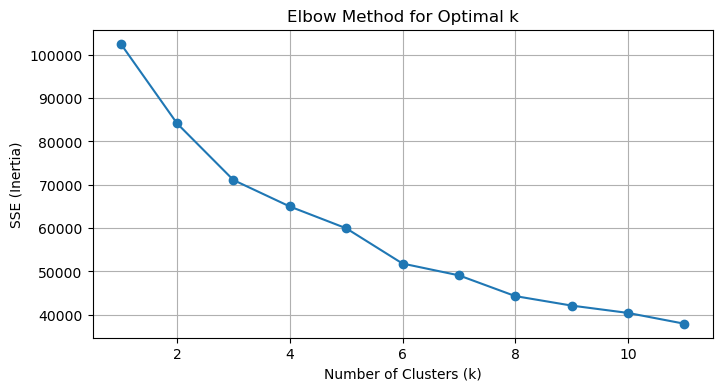

Optimal number of clusters: 6


In [ ]:
# set up kmeans_kwargs dictionary
kmeans_kwargs = {
    "init": "random",
    "n_init": 10,
    "max_iter": 300,
    "random_state": 42
}

sse = []

for k in range(1, 12):
    kmeans = KMeans(n_clusters=k, **kmeans_kwargs)
    kmeans.fit(scaled_features)
    sse.append(kmeans.inertia_)

plt.figure(figsize=(8, 4))
plt.plot(range(1, 12), sse, marker='o')
plt.xlabel("Number of Clusters (k)")
plt.ylabel("SSE (Inertia)")
plt.title("Elbow Method for Optimal k")
plt.grid(True)
plt.show()

knee = KneeLocator(range(1, 12), sse, curve="convex", direction="decreasing")
print(f"Optimal number of clusters: {knee.elbow}")

In [ ]:
# run KMeans using the optimal number of clusters
#fit KMeans to data
final_kmeans = KMeans(n_clusters=6, **kmeans_kwargs)
final_kmeans.fit(scaled_features)
# Fit final KMeans with optimal clusters
final_kmeans = KMeans(n_clusters=6, **kmeans_kwargs)
final_kmeans.fit(scaled_features)

# Add cluster labels to your original features dataframe
features['cluster'] = final_kmeans.labels_

# Preview
features.head()
features['cluster'] = final_kmeans.labels_

# Preview
features.head()

,host_is_superhost,availability_365,short_term,accommodates,bathrooms,price_lg,beds,review_scores_rating,avg_air_quality,room_type_Entire home/apt,room_type_Hotel room,room_type_Private room,room_type_Shared room,cluster
0,0,172,0,1,1.0,3.761200,1.0,4.95,1.732078,False,False,True,False,1
1,1,186,1,2,1.0,4.248495,1.0,4.94,1.732078,False,False,True,False,1
2,1,178,0,1,1.0,3.761200,1.0,4.50,1.720434,False,False,True,False,1
3,1,49,1,2,1.0,4.672829,2.0,4.92,1.732078,True,False,False,False,4
4,1,301,0,2,1.0,3.663562,2.0,4.78,1.720434,False,False,True,False,1


**29) How many clusters were deemed optimal? Explain how the elbow rule is used to determine the optimal number of clusters?**

6 were deemed optimal - The “elbow” point, where SSE reduction sharply levels off—indicates diminishing returns and is chosen as the optimal number.

**30) Next, create a centroid table and use the centroid values to produce labels for each of your clusters of properties. For each label, provide a brief explanation for the title you've created.**

In [28]:
# save cluster centroids to an object called 'centroids'
centroids = pd.DataFrame(final_kmeans.cluster_centers_, columns=scaled_features.columns)

centroids

,host_is_superhost,availability_365,short_term,accommodates,bathrooms,price_lg,beds,review_scores_rating,avg_air_quality,room_type_Entire home/apt,room_type_Hotel room,room_type_Private room,room_type_Shared room
0,-1.330095,0.028022,0.341072,-0.193469,-0.258612,-0.167738,-0.274425,-0.444340,0.040754,0.302157,-0.069571,-0.291539,-0.022523
1,-0.230895,-0.285632,-0.542622,-1.140991,-0.666317,-1.094679,-0.638533,-0.350462,-0.335289,-3.309536,-0.069571,3.406136,0.263144
2,0.410297,0.473584,0.329094,1.244640,1.145870,0.856818,0.928138,0.211897,0.195103,0.302157,-0.069571,-0.291539,-0.022523
3,-0.352917,0.861539,0.346353,-0.739607,-0.674361,0.269605,-0.666966,-1.215170,-0.181203,-3.309536,14.373770,-0.291539,-0.022523
4,0.745459,-0.284612,0.346353,-0.425175,-0.471173,-0.141226,-0.291373,0.223484,0.018221,0.302157,-0.069571,-0.291539,-0.022523
5,-0.358076,-0.185471,-2.887230,-0.509629,-0.284837,-0.621074,-0.315157,0.070864,-0.470008,0.302157,-0.069571,-0.291539,-0.022523




*   **Cluster_0 label:** Non-superhost, low-price, low-review, average availability - Hosts in this cluster are least likely to be superhosts, with slightly below-average price and review scores.
*  **Cluster_1 label:** Small, low-cost rentals with low review scores - These properties have low values across accommodates, bathrooms, beds, price, and review scores.
*   **Cluster_2 label:** Premium large properties with great reviews - High accommodates, bathrooms, beds, and review scores. Also higher price and availability. Ideal for investment.
*   **Cluster_3 label:** Shared rooms with low ratings - Extremely low review_scores_rating, high value in room_type_Shared room, and low superhost presence.
*   **Cluster_4 label:** Superhost-managed units with solid ratings and moderate pricing - Strong positive superhost value, good review scores, and middle-range price—likely well-run entire units.
*   **Cluster_5 label:** Long-term low-availability rentals with poor air quality - Highly negative in short_term and availability_365, with below-average air quality and low price.


**31) If you were to encourage Aggie Investments to invest in a particular segment (cluster) of properties, which cluster would you choose and why?**

cluster 2 - it represents a well-performing, high-capacity, high-rated properties that are likely to deliver both strong guest satisfaction and return on investment.

**32) Finally, create a visualization to back-up your property cluster recommendation. Include a description of the visualization to indicate how it supports your claim.**

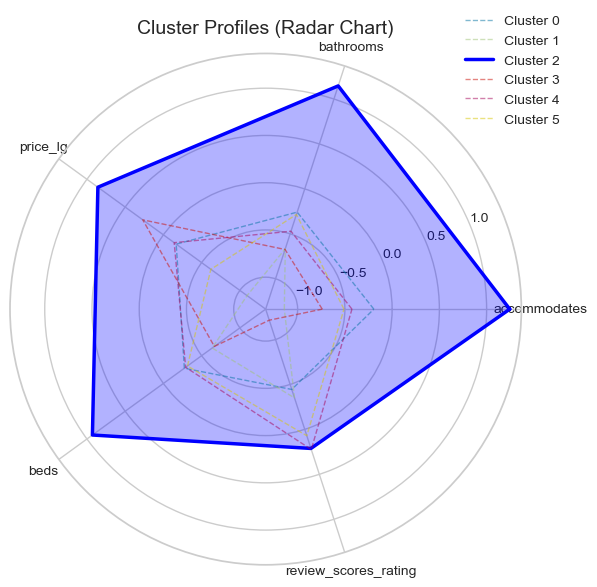

In [ ]:
# produce visualization to highlight why your cluster is the best!
radar_vars = ['accommodates', 'bathrooms', 'price_lg', 'beds', 'review_scores_rating']
cluster_centroids = centroids[radar_vars]

num_vars = len(radar_vars)

angles = np.linspace(0, 2 * np.pi, num_vars, endpoint=False).tolist()
angles += angles[:1] 

fig, ax = plt.subplots(figsize=(8, 6), subplot_kw=dict(polar=True))

for i, row in cluster_centroids.iterrows():
    values = row.tolist()
    values += values[:1]  
    if i == 2: 
        ax.plot(angles, values, linewidth=2.5, linestyle='solid', label=f'Cluster {i}', color='blue')
        ax.fill(angles, values, color='blue', alpha=0.3)
    else:
        ax.plot(angles, values, linewidth=1, linestyle='dashed', label=f'Cluster {i}', alpha=0.5)
        
ax.set_xticks(angles[:-1])
ax.set_xticklabels(radar_vars)
ax.set_title("Cluster Profiles (Radar Chart)", fontsize=14)
ax.legend(loc='upper right', bbox_to_anchor=(1.1, 1.1))
plt.tight_layout()
plt.show()


**Description**:

The radar chart visualizes the centroid profiles of six property clusters across key features such as accommodates, bathrooms, price_lg, beds, and review_scores_rating. Each colored line represents the average standardized value for a given feature within a cluster. Notably, Cluster 2, shown in bold blue, consistently scores higher across all dimensions—indicating that properties in this cluster tend to accommodate more guests, have more bathrooms and beds, charge higher prices, and receive better reviews—making it a highly desirable investment segment for Aggie Investments.

## **Summarize findings**

**33) Briefly summarize what you learned from this analysis to a non-statistician. Write a few sentences about 1) the purpose of the analyses conducted and 2) what you learned about this data set from your analyses. Write your response as if you were addressing a business manager (avoid using statistics jargon) and provide the main take-aways:**

The goal of this analysis was to uncover patterns in property features and group similar listings to help Aggie Investments make smarter buying decisions. By grouping properties with similar traits, we identified which types tend to be more successful—higher priced, larger, and more positively reviewed. Our main takeaway is that Cluster_2 represents high-performing, guest-preferred properties that offer both strong value and profitability, making it a compelling target for future investment.